# Exercise A - Karhunen-Loeve series expansion method 

In [4]:
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go


In [5]:
def omega_equation_1(w: float, a: float = 2.5, b: float = 2):
    """
    Return the left part of the equation to solve for w:
    1/b - w * tan(w * a) = 0
    """
    return 1/b - w * np.tan(w * a)


def omega_equation_2(w_toned: float, a: float = 2.5, b: float = 2):
    """
    Return the left part of the equation to solve for w':
    w' + (1/b) tan(w' * a) = 0
    """
    return w_toned + (1/b) * np.tan(w_toned * a)


def lambdas_values_calculation(w: float, a: float = 2.5, b: float = 2):
    """
    Calculate lambda from w:
    l = 2b / (1 + w^2 * b^2)
    """
    return 2.0*b / (1.0 + (w**2) * (b**2))


def omega_solutions(n: int, a: float = 2.5, b: float = 2):
    """
    Solve equations for omega (w) and omega tonned (w') and return their values.
    """
    w = fsolve(omega_equation_1, (n-1) * np.pi/a + 1e-4).item()
    w_toned = fsolve(omega_equation_2, (n-0.5) * np.pi/a + 1e-4).item()
    return w, w_toned


def explained_variance(lambda_values: np.array, lambda_toned_values: np.array) -> float:
    """
    Return the calculated explained variance.
    """
    return (1/5) * np.sum(lambda_values + lambda_toned_values)


def eigenfunction(x: float, w: np.array, a: float = 2.5):
    """
    Return the φ_n(x) value of the eigenfunction.
    """
    phi = np.cos(w * x) / np.sqrt(a + np.sin(w*2*a)/(w*2))
    return phi


def eigenfunction_toned(x: float, w_toned: float, a: float = 2.5):
    """
    Return the φ_n'(x) value of the toned eigenfunction.
    """
    phi_toned = np.sin(w_toned * x) / (np.sqrt(a - np.sin(w_toned*2*a)/(w_toned*2)))
    return phi_toned


def realizations(k:int, w_values, w_toned_values, sqrt_lambda_values, sqrt_lambda_toned_values, a=2.5, b=2, N=5000):
    """
    Generate N realizations of E(x).
    """
    number_of_x_points = 1000
    realizations_array = np.zeros((N,number_of_x_points))
    Xs = np.linspace(-a, a, number_of_x_points)

    w_array, w_toned_array = np.array(w_values), np.array(w_toned_values)
    term1 = np.zeros((k, number_of_x_points))
    term2= np.zeros((k, number_of_x_points))

    # generate all k terms of the series expansion for each x point of the Xs range
    for idx in range(k):
        term1[idx,:] = sqrt_lambda_values[idx]*eigenfunction(Xs, w_array[idx], a=a)
        term2[idx,:] = sqrt_lambda_toned_values[idx]*eigenfunction_toned(Xs, w_toned_array[idx], a=a)

    # generate N realizations
    for idx in range(N):
        # generate k xis
        xis = np.random.standard_normal(k)
        xis_toned = np.random.standard_normal(k)
        first_terms = np.zeros((k, number_of_x_points))
        second_terms = np.zeros((k, number_of_x_points))
        for idx2 in range(k):
            first_terms[idx2, :] = term1[idx2, :] * xis[idx2]
            second_terms[idx2, :] = term2[idx2,:] * xis_toned[idx2]
        realizations_array[idx,:] = 10 * (1 + first_terms.sum(0) + second_terms.sum(0))
    
    return realizations_array

In [6]:
lambda_values, lambda_toned_values = [], []
w_values, w_toned_values = [], []
explained_variance_values = []
n = 0
explained_variance_value = 0
EXPLAINED_VARIANCE_THRESHOLD = 0.99

while (n <= 10000) and (explained_variance_value < EXPLAINED_VARIANCE_THRESHOLD):
    n += 1
    w, w_toned = omega_solutions(n)
    w_values.append(w)
    w_toned_values.append(w_toned)

    # w_values and w_toned_values verified to be correct

    lambda_value, lambda_toned_value = lambdas_values_calculation(w), lambdas_values_calculation(w_toned)
    lambda_values.append(lambda_value)
    lambda_toned_values.append(lambda_toned_value)

    # lambda_values and lambda_toned_values verified to be correct

    explained_variance_value = explained_variance(np.array(lambda_values), np.array(lambda_toned_values))
    explained_variance_values.append(explained_variance_value)


In [7]:
print(f'Number of terms kept: {n}')

Number of terms kept: 26


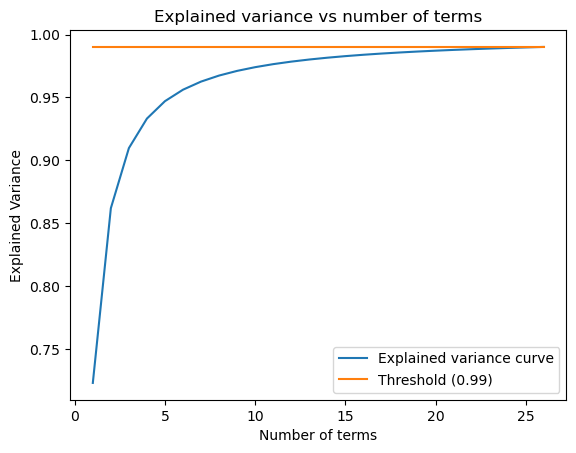

In [8]:
fig, ax = plt.subplots()
ax.plot(np.arange(1, n+1), explained_variance_values, label='Explained variance curve')
ax.plot(np.arange(1, n+1), 0.99 * np.ones(n), label=f'Threshold ({EXPLAINED_VARIANCE_THRESHOLD})')
ax.set_xlabel('Number of terms')
ax.set_ylabel('Explained Variance')
plt.title('Explained variance vs number of terms')
plt.legend()
plt.show()

In [9]:
k = n  # number of terms to keep

In [10]:
sqrt_lambda_values, sqrt_lambda_toned_values = np.sqrt(lambda_values), np.sqrt(lambda_toned_values)

In [11]:
E_realizations = realizations(k, 
                              w_values,
                              w_toned_values,
                              sqrt_lambda_values,
                              sqrt_lambda_toned_values
                            )

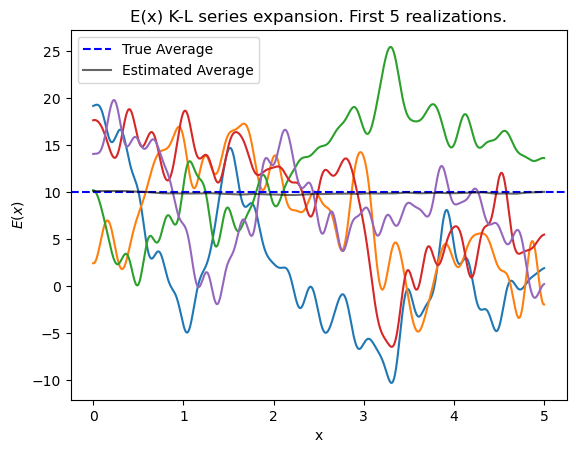

In [12]:
fig, ax = plt.subplots()
Xs = np.linspace(0, 5, 1000)

for realization_idx in range(5):
    ax.plot(Xs, E_realizations[realization_idx])

# add true average line
ax.axhline(10, 
           linestyle='--', 
           label='True Average',
           color='blue'
    )

# add estimated average line
estimated_average = np.mean(E_realizations, 0)
ax.plot(Xs, 
        estimated_average,
        label='Estimated Average',
        alpha=0.6,
        color='black' 
    )

ax.set_title(f'Ε(x) K-L series expansion. First 5 realizations.')
ax.set_xlabel('x')
ax.set_ylabel(r'$E(x)$')
ax.legend()
plt.show()


Ensemble variance

In [13]:
number_of_x_points = 1000
a = 2.5
Xs = np.linspace(-a, a, number_of_x_points)

w_array, w_toned_array = np.array(w_values), np.array(w_toned_values)

term1 = np.zeros((k, number_of_x_points))
term2= np.zeros((k, number_of_x_points))

for idx in range(k):
    term1[idx,:] = lambda_values[idx] * (eigenfunction(Xs, w_array[idx], a=a))**2
    term2[idx,:] = lambda_toned_values[idx] * (eigenfunction_toned(Xs, w_toned_array[idx], a=a))**2
    
true_variance = 100.0*(term1.sum(0) + term2.sum(0))

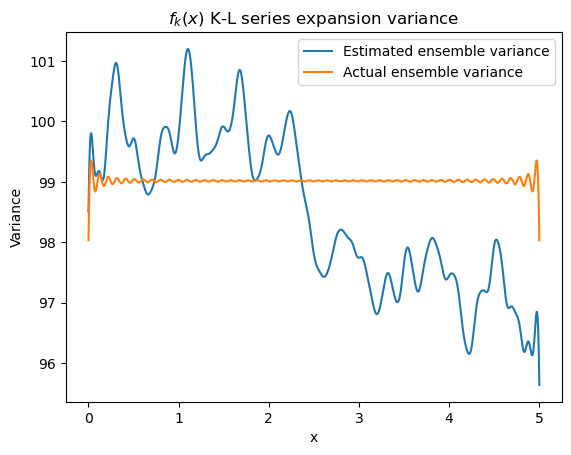

In [14]:

fig, ax = plt.subplots()
ax.set_title('$f_k(x)$ K-L series expansion variance')
ax.plot(np.linspace(0, 5, number_of_x_points), np.var(E_realizations, axis=0), label='Estimated ensemble variance')
ax.plot(np.linspace(0, 5, number_of_x_points), true_variance, label='Actual ensemble variance')
ax.set_xlabel('x')
ax.set_ylabel('Variance')
ax.legend()
plt.show()

# Exercise B - Spectral Representation Method

In [15]:
def G(w):
    """
    One-sided spectrum definition G(w) of the process X(t).
    """
    if 1<=w<=2:
        return w-1
    elif 2<w<=3:
        return 3-w
    else:
        return 0

In [16]:
np.random.seed(42)  # set random state for reproducability

N = 5000  # number of realizations
M = 20  # number of terms to keep in the series expansion

number_of_t_points = 1000  # number of time points to take
t_range = np.linspace(0, 10, number_of_t_points)  # time range in [0, 10]
w_range = np.linspace(1, 3, M)

dw = (w_range[-1] - w_range[0]) / (M-1)  # Δw

G_vectorized = np.vectorize(G)  # vectorize function so that
# it can be applied to numpy arrays and not single numbers

A_n = np.sqrt(2 * G_vectorized(w_range) * dw)  # A_n for n=0,1,2,...,M-1
A_n = np.reshape(A_n, (-1, 1))
"""
Will create the matrix B_n = w_n * t :
[
 [w0*t0, w0*t1, ..., w0*t999],
 [w1*t0, w1*t1, ..., w1*t999],
 ...
 [w_M-1*t0, w_M-1*t1, ...., w_M-1*t999]
]
"""
B_n = np.outer(w_range, t_range)

# realizations = []
realizations = np.array([])
for realization_idx in range(N): 
    # then we add Φ_n to B_n to form C_n = B_n + Φ_n = w_n * t + Φ_n
    Phi_n = np.random.uniform(0, 2 * np.pi, size = (M, 1))
    C_n = B_n + Phi_n

    # then we for the cosine D_n = cos(C_n) = cos(w_n * t + Φ_n)
    D_n = np.cos(C_n)

    # then we form the term in the series E_n = A_n * cos(w_n * t + Φ_n)
    E_n = A_n * D_n

    X_t = np.sqrt(2) * np.sum(E_n, axis=0)
    # realizations.append(X_t)
    realizations = np.append(realizations, X_t)

In [17]:
realizations = realizations.reshape(N, -1)

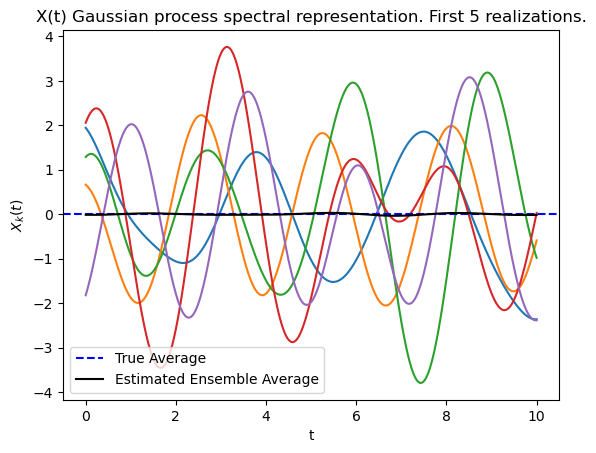

In [43]:
fig, ax = plt.subplots()

Ts = np.linspace(0, 10, number_of_t_points)

for realization_idx in range(5):
    ax.plot(Ts, realizations[realization_idx])

# add true average line
ax.axhline(0, 
           linestyle='--', 
           label='True Average',
           color='blue'
)

# add estimated average line
estimated_average = np.mean(realizations, 0)

ax.plot(Ts, 
        estimated_average,
        label='Estimated Ensemble Average',
        color='black'
)

ax.set_title(f'X(t) Gaussian process spectral representation. First 5 realizations.')
ax.set_xlabel('t')
ax.set_ylabel(r'$X_k(t)$')
ax.legend()
plt.show()

In [19]:
true_variance = 2 * dw * np.sum(G_vectorized(w_range))
print(f'True variance for the series terms selected: {true_variance}')

estimated_variance = np.var(realizations)
print(f'Estimated variance from {N} realizations: {estimated_variance}')

True variance for the series terms selected: 1.9944598337950137
Estimated variance from 5000 realizations: 1.9777644794718492


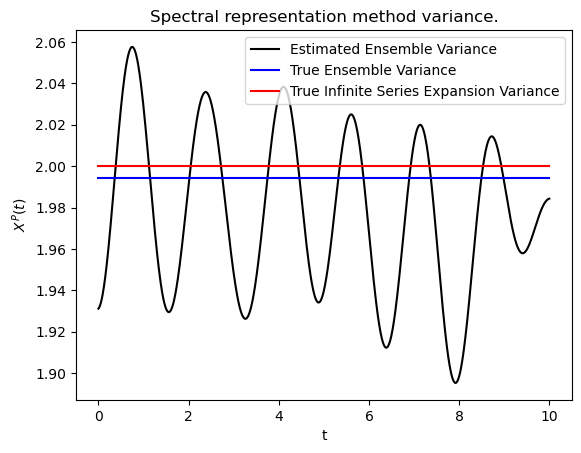

In [42]:
fig, ax = plt.subplots()

Ts = np.linspace(0, 10, number_of_t_points)

# add estimated variance line
estimated_variance_2 = np.var(realizations, 0)

ax.plot(Ts, 
        estimated_variance_2,
        label='Estimated Ensemble Variance',
        color='black'
)


# add true ensemble variance line
ax.plot(Ts, 
        np.array([true_variance] * number_of_t_points),
        label='True Ensemble Variance',
        color='blue'
)

# add true infinite series variance line
ax.plot(Ts, 
        np.array([2] * number_of_t_points),
        label='True Infinite Series Expansion Variance',
        color='red'
)


ax.set_title(f'Spectral representation method variance.')
ax.set_xlabel('t')
ax.set_ylabel(r'$X^P(t)$')
ax.legend()
plt.show()

Single variation temporal average and variance

Realization with idx=0:
Mean=-0.06371380409295195
Variance=1.3634273473286749


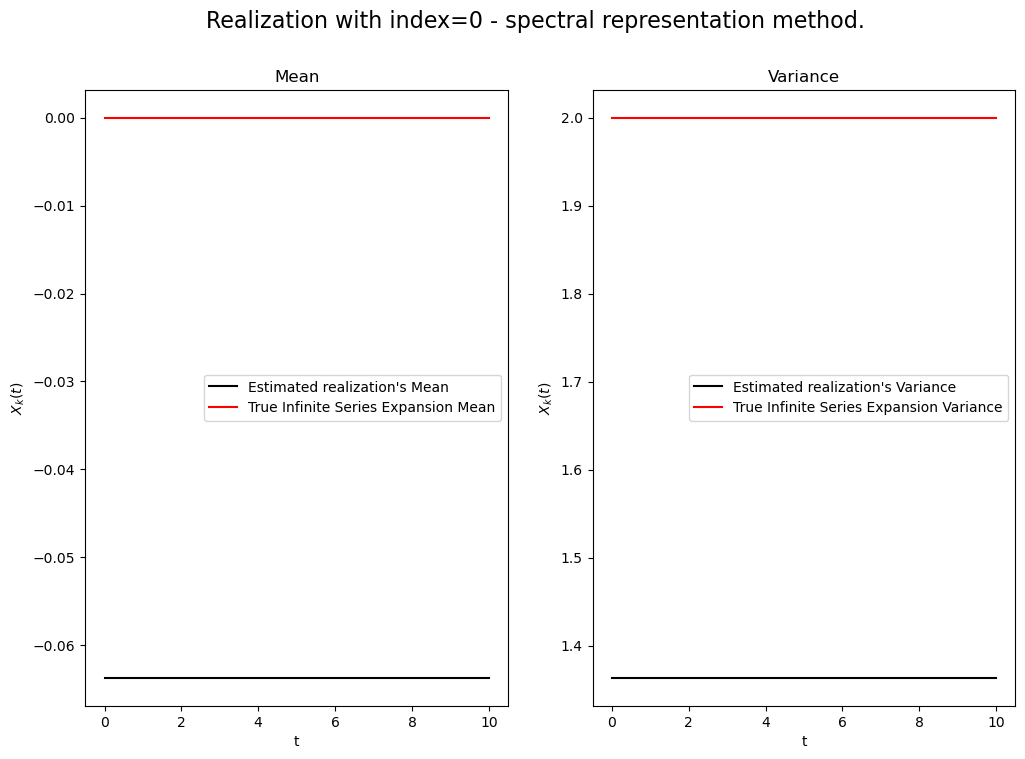

In [73]:
realization_selected_idx = 0

realization = realizations[realization_selected_idx]

realization_mean = np.mean(realization)
realization_variance = np.var(realization)

print(f'Realization with idx={realization_selected_idx}:')
print(f'Mean={realization_mean}')
print(f'Variance={realization_variance}')

# visualization
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
fig.suptitle(f'Realization with index={realization_selected_idx} - spectral representation method.', fontsize=16)

# first plot - average 
ax[0].plot(Ts, 
        np.array([realization_mean] * number_of_t_points),
        label="Estimated realization's Mean",
        color='black'
)

# add true infinite series mean line
ax[0].plot(Ts, 
        np.array([0] * number_of_t_points),
        label='True Infinite Series Expansion Mean',
        color='red'
)


ax[0].set_title(f'Mean')
ax[0].set_xlabel('t')
ax[0].set_ylabel(r'$X_k(t)$')
ax[0].legend()

# second plot - variance
ax[1].plot(Ts, 
        np.array([realization_variance] * number_of_t_points),
        label="Estimated realization's Variance",
        color='black'
)

# add true infinite series variance line
ax[1].plot(Ts, 
        np.array([2] * number_of_t_points),
        label='True Infinite Series Expansion Variance',
        color='red'
)


ax[1].set_title(f'Variance')
ax[1].set_xlabel('t')
ax[1].set_ylabel(r'$X_k(t)$')
ax[1].legend()


plt.show()